In [2]:
from time import time

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import time
import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
import tensorflow as tf
import random as r
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import copy

import Config
import Dataloader as DL

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
datasets=[
    "KDD Cup 1999",                            #0
    "Microsoft Challenge BIG 2015"             #1
]
presets = {
    "KDD Cup 1999": {
        "NeuralHD": [300,2,3,.1],
        "OnlineHD": [300,1.0,.1,30,True],
        "MLP": [100,5,.001],
        "SVM": [10000]
    },
    "Microsoft Challenge BIG 2015": {
        "NeuralHD": [3000,6,10,.1],
        "OnlineHD": [3000,1.0,.1,30,True],
        "MLP": [100,30,.001],
        "SVM": [None]
    }
}
def normalized(x,y):
    xtrain, x_test, ytrain, y_test = None,None,None,None
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y, shuffle=True)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    return x.numpy(), x_test.numpy(), y.numpy(), y_test.numpy(), scaler
def getuniquevalues(columnname,df):
    values={}
    i=0
    for entry in df[columnname]:
        if entry not in values:
            values[entry]=i
            i+=1
    return values
def get_dataset(name):
    if name==datasets[0]:
        path="../../Data/"
        attacks_types = {
            'normal': 'normal','back': 'dos','buffer_overflow': 'u2r','ftp_write': 'r2l','guess_passwd': 'r2l',
        'imap': 'r2l','ipsweep': 'probe','land': 'dos','loadmodule': 'u2r','multihop': 'r2l','neptune': 'dos',
        'nmap': 'probe','perl': 'u2r','phf': 'r2l','pod': 'dos','portsweep': 'probe','rootkit': 'u2r','satan': 'probe',
        'smurf': 'dos','spy': 'r2l','teardrop': 'dos','warezclient': 'r2l','warezmaster': 'r2l',
        }
        cols ="""duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,
        urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,
        num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,
        count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,
        diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,
        dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,
        dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate"""
        
        columns =[]
        for c in cols.split(','):
            if(c.strip()):
                columns.append(c.strip())
        print(len(columns))
        columns.append('target')
        print(len(columns))

        attack_categories=["dos","u2r","r2l",'probe','normal']
        df = pd.read_csv(path+"kddcup.data_10_percent.gz", names = columns)
        df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])
        del df['target']
        df.head()
        num_cols = df._get_numeric_data().columns
        
        cate_cols = list(set(df.columns)-set(num_cols))
        cate_cols.remove('Attack Type')
        for col in cate_cols:
            df[col]=df[col].map(getuniquevalues(col,df))
        data=df.to_numpy()
        Y=df['Attack Type'].map(getuniquevalues('Attack Type',df))
        Y=Y.to_numpy()
        X=data[:,:-1]
        print(Y.shape)
        print(X.shape)
        print(getuniquevalues('Attack Type',df))
        xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)
    if name==datasets[1]:
        path="../../Data/malware-classification/"
        map={}
        mapping=pd.read_csv(path + "trainLabels.csv")
        Y=mapping["Class"].to_numpy()
        for i in range(0,len(Y)):
            map[mapping["Id"][i]]=mapping["Class"][i]-1
        byte_features=pd.read_csv(path+"result.csv")
        byte_features['ID']  = byte_features['ID'].str.split('.').str[0]
        byte_features.head(3)
        byte_features['ID']=byte_features['ID'].map(map)
        data=byte_features.to_numpy()
        X=data[:,1:]
        Y=data[:,0]
        xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)
    return xtrain,x_test,ytrain,y_test

datasetname="Microsoft Challenge BIG 2015"

xtrain,x_test,ytrain,y_test=get_dataset(datasetname)

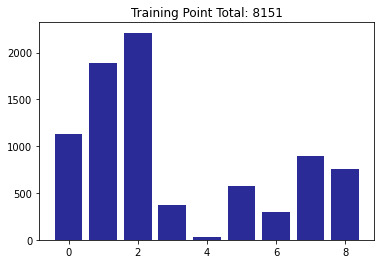

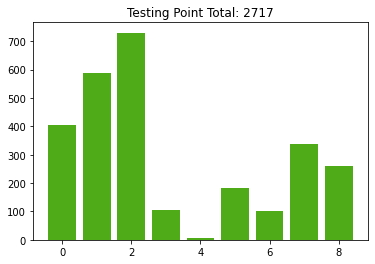

In [4]:
points=[]
for i in range (0,len(np.unique(ytrain))):
    points.append(len(xtrain[ytrain==i]))
plt.bar(range(0,len(points)),points, color=np.random.rand(3,))
plt.title("Training Point Total: " + str(sum(points)))
plt.show()
points=[]
for i in range (0,len(np.unique(y_test))):
    points.append(len(x_test[y_test==i]))
plt.bar(range(0,len(points)),points, color=np.random.rand(3,))
plt.title("Testing Point Total: " + str(sum(points)))
plt.show()

In [221]:
def get_class_accuracy_breakdown(model,x_test,y_test, output=False):
    acc=[]
    points=[]
    try:
        for i in range (0,len(np.unique(y_test))):
            yhat= model.predict(x_test[y_test==i])
            if len(yhat.shape)==2:
                yhat=np.array([row.argmax() for row in yhat])
            acc.append((yhat==i).mean())
            points.append(len(yhat))
    except:
        for i in range (0,len(np.unique(y_test))):
            yhat= model.predict(torch.from_numpy(x_test[y_test==i]))
            acc.append((yhat==i).float().mean())
            points.append(len(yhat))
    # print(yhat[:30])
    totacc=sum([acc[i]*points[i] for i in range(0,len(acc))])/sum(points)
    if output:
        plt.bar(range(0,len(acc)),acc,color=np.random.rand(3,))
        plt.title("Accuracy Total: " + str(totacc))
        plt.show()
    return totacc

In [7]:
xtraintorch=torch.from_numpy(xtrain)
ytraintorch=torch.from_numpy(ytrain)
x_testtorch=torch.from_numpy(x_test)
y_testtorch=torch.from_numpy(y_test)

In [684]:

#change
def cos_cdist(x1 : torch.Tensor, x2 : torch.Tensor, eps : float = 1e-8):
    #Cosine Similarity
    eps = torch.tensor(eps, device=x1.device)
    norms1 = x1.norm(dim=1).unsqueeze_(1).max(eps)
    norms2 = x2.norm(dim=1).unsqueeze_(0).max(eps)
    cdist = x1 @ x2.T
    cdist.div_(norms1).div_(norms2)
    return cdist
class NeuralHD:
    def __init__(self, classes : int, features : int, dim : int = 400, batch_size=1):
        #Configure for hdb, hdc, and hde classes
        self.param=Config.config
        self.param['nClasses'] = classes
        self.param['nFeatures']= features
        #hypervector size
        self.param['D']=dim
        self.param['lr']=.0001
        self.batch_size=batch_size
        self.base = torch.empty(self.param['D']).uniform_(0.0, 2*math.pi)
        #encoder
        self.hde=None
        #classifier
        self.hdc=None
        # Initialize basis in gaussian distribution
        self.basis = torch.normal(0,1,size=(self.param["D"],self.param["nFeatures"]))
        # Initialize classification hypervectors
        self.classes = torch.zeros((self.param['nClasses'], self.param['D']))
        self.prevacc=0
        # self.param['lr']=.1
        # self.hdc = HD_classifier(self.param["D"], self.param["nClasses"], 0)
        self.trainaccuracies=[]
        self.testaccuracies=[]
        self.medians=[]
    def __call__(self, x : torch.Tensor):
        #return predicted values
        return self.predict(x)
    def encode(self,x):
        n = x.size(0)
        bsize = min([x.size(1),1024])
        h = torch.empty(n, self.basis.shape[0], device=x.device, dtype=x.dtype)
        temp = torch.empty(bsize, self.basis.shape[0], device=x.device, dtype=x.dtype)

        # we need batches to remove memory usage
        for i in range(0, n, bsize):
            torch.matmul(x[i:i+bsize], self.basis.T, out=temp)

            # self.noise ... I haven't seen any indication that it works better 
            # if self.noise:
            torch.add(temp, self.base, out=h[i:i+bsize])#h[i:i+bsize]=temp# torch.add(temp, self.base, out=h[i:i+bsize])
            # else:
            # h[i:i+bsize]=temp

            h[i:i+bsize].cos_()#.mul_(temp.sin_())
        # print(h.shape)
        return h
    def train(self,h,y):
        # r=torch.randperm(y.size(0))
        # y=y[r]
        # h=h[r,:]
        n = h.size(0)
        batch_size = min([y.size(0), self.batch_size])#64
        for i in range(0, n, batch_size):
            h_ = h[i:i+batch_size]
            y_ = y[i:i+batch_size]
            scores = cos_cdist(h_, self.classes)#cos
            y_pred = scores.argmax(1)
            wrong = y_ != y_pred

            # computes alphas to update model
            # alpha1 = 1 - delta[lbl] -- the true label coefs
            # alpha2 = delta[max] - 1 -- the prediction coefs
            aranged = torch.arange(h_.size(0), device=h_.device)
            alpha1 = (1.0 - scores[aranged,y_]).unsqueeze_(1)
            alpha2 = (scores[aranged,y_pred] - 1.0).unsqueeze_(1)

            for lbl in y_.unique():
                m1 = wrong & (y_ == lbl) # mask of missed true lbl
                m2 = wrong & (y_pred == lbl) # mask of wrong preds
                self.classes[lbl] += self.param['lr']*(alpha1[m1]*h_[m1]).sum(0)
                self.classes[lbl] += self.param['lr']*(alpha2[m2]*h_[m2]).sum(0)
            # if self.test(h,y)<self.prevacc:
            #     for lbl in y_.unique():
            #         m1 = wrong & (y_ == lbl) # mask of missed true lbl
            #         m2 = wrong & (y_pred == lbl) # mask of wrong preds
            #         self.classes[lbl] -= self.param['lr']*(alpha1[m1]*h_[m1]).sum(0)
            #         self.classes[lbl] -= self.param['lr']*(alpha2[m2]*h_[m2]).sum(0)
            # else:
            #     self.prevacc=self.test(h,y)
    def train2(self,h,y):
        # def fit(self, data, label, param = None):

        assert self.param["D"] == h.size(1)
        #if self.first_fit:
        #    sys.stderr.write("Fitting with configuration: %s \n" % str([(k,param[k]) for k in self.options]))

        # Actual fitting

        # handling dropout

        # fit
        r = torch.randperm(h.shape[0])
        correct = 0
        count = 0
        for i in r:
            sample = h[i] 
            answer = y[i]
            #maxVal = -1
            #guess = -1
            #for m in range(self.nClasses):
            #    val = kernel(self.classes[m], sample)
            #    if val > maxVal:
            #        maxVal = val
            #        guess = m
            vals = cos_cdist(sample.unsqueeze(1).T, self.classes)
            # print(vals)
            guess = torch.argmax(vals)
            if guess != answer:
                self.classes[guess]-=self.param['lr']*h[i]*(1-vals[0,guess])
                self.classes[answer]+=self.param['lr']*h[i]*(1-vals[0,answer])
                # acc=self.test2(h[r][:100],y)
                # if acc<=self.prevacc:
                #     self.classes[guess]+=self.param['lr']*h[i]
                #     self.classes[answer]-=self.param['lr']*h[i]
                # else:
                #     self.prevacc=acc
            else:
                correct += 1
            count += 1
        return correct / count
    
    def train3(self,h,y):
        # def fit(self, data, label, param = None):

        assert self.param["D"] == h.size(1)
        #if self.first_fit:
        #    sys.stderr.write("Fitting with configuration: %s \n" % str([(k,param[k]) for k in self.options]))

        # Actual fitting

        # handling dropout

        # fit
        r = torch.randperm(y.size(0))
        y=y[r]
        h=h[r,:]
        correct = 0
        count = 0
        for i in range(0,y.size(0),self.batch_size):
            sample = h[i:i+self.batch_size] 
            answers = y[i:i+self.batch_size]
            #maxVal = -1
            #guess = -1
            #for m in range(self.nClasses):
            #    val = kernel(self.classes[m], sample)
            #    if val > maxVal:
            #        maxVal = val
            #        guess = m
            vals = cos_cdist(sample, self.classes)
            # print(vals)
            guesses = vals.argmax(1)
            # print(guesses)
            for j in range(0,answers.size(0)):
                if guesses[j] != answers[j]:
                    self.classes[guesses[j]]-=self.param['lr']*h[i+j]*(1-vals[0,guesses[j]])
                    self.classes[answers[j]]+=self.param['lr']*h[i+j]*(1-vals[0,answers[j]])
                    # acc=self.test2(h[r][:100],y)
                    # if acc<=self.prevacc:
                    #     self.classes[guess]+=self.param['lr']*h[i]
                    #     self.classes[answer]-=self.param['lr']*h[i]
                    # else:
                    #     self.prevacc=acc
                else:
                    correct += 1
                count += 1
        return correct / count

    def predict(self,x):
        #return predictions based on similarity of encoded inputs to classification hypervectors
        return  cos_cdist(self.encode(x), self.classes).argmax(1)
    def fit(self,traindata, trainlabels,
                   epochs,
                   regenloops,  # list of effective dimensions to reach 
                   fractionToDrop # drop/regen rate 
                    ):
        # find encoded training vectors

        # calculate amount of dropped dimensions based on percent and original dimension
        amountDrop = int(fractionToDrop * self.param['D'])#self.param.D?
        # print("Updating times:", regenloops)

        for i in range(regenloops+1): # For each eDs to reach, will checkpoints
            # compute new encoded data
            trainencoded = self.encode(traindata)
            testencoded = self.encode(x_testtorch)
            
            # print("regenloop: " + str(i))
            # train for specified number of epochs
            # Do the train 
            self.prevacc=0
            iterscorestrain=[]
            iterscorestest=[]
            maxval=0
            temp=None
            for j in range(epochs):
                # do one pass of training
                # print(self.classes[:,8])
                result=self.train3(trainencoded, trainlabels)
                # print(result)
                trainaccuracy= self.test(trainencoded,trainlabels)
                testaccuracy= self.test(testencoded,y_testtorch)
                iterscorestrain.append(trainaccuracy)
                iterscorestest.append(testaccuracy)

                if trainaccuracy>maxval:
                    temp=copy.deepcopy(self.classes)
                    maxval=trainaccuracy
                    print(testaccuracy)
                # print(j)
            self.classes=temp
            
            self.trainaccuracies+=iterscorestrain
            self.testaccuracies+=iterscorestest
            self.medians.append(np.median(np.array(iterscorestrain)))
                # print(self.prevacc)
            #if its the last regeneration training, stop before doing another dimension drop; stop if 100% accuracy
            if i==regenloops:
                return #self.hdc,self.hde - unnecessary now that hdc and hde are within a class
            # print("regen" +str(i))
            #do the dimension drop and regeneration
            normed_classes = torch.nn.functional.normalize(self.classes)
            #calculate variances for each dimension
            var = torch.var(normed_classes, 0) 
            assert len(var) == self.param['D']
            # rank each entry in variances from smallest to largest
            order = torch.argsort(var)
            #drop amountDrop bases
            toDrop = order[:amountDrop]
            #            ----------------
            #attempted reverse drop
            # if amountDrop<0:
            #     toDrop = order[-amountDrop:]
            #            ----------------
            #Update basis
            #For each dimension designated to be dropped
            for i in toDrop:
                #generate a new ith vector in the basis
                self.basis[i] = torch.normal(self.param["mu"],self.param["sigma"], size=(self.param['nFeatures'],))
            #Update Classes
            #            --------------
            #This code was left out. Maybe useful?
            for i in toDrop:
                self.classes[:,i] = torch.zeros(self.param['nClasses'])
            #            --------------

            self.classes=torch.nn.functional.normalize(self.classes)
            # self.batch_size=int(np.ceil(self.batch_size/2))
            # if self.batch_size==1:
            #     self.param['lr']=self.param['lr']/2
        return "error","error"
    def _iterative_fit(self, h, y, lr, epochs):
        h=self.encode(h)
        n = h.size(0)
        for epoch in range(epochs):
            for i in range(0, n, self.batch_size):
                h_ = h[i:i+self.batch_size]
                y_ = y[i:i+self.batch_size]
                scores = cos_cdist(h_, self.classes)
                y_pred = scores.argmax(1)
                wrong = y_ != y_pred

                # computes alphas to update model
                # alpha1 = 1 - delta[lbl] -- the true label coefs
                # alpha2 = delta[max] - 1 -- the prediction coefs
                aranged = torch.arange(h_.size(0), device=h_.device)
                alpha1 = (1.0 - scores[aranged,y_]).unsqueeze_(1)
                alpha2 = (scores[aranged,y_pred] - 1.0).unsqueeze_(1)

                for lbl in y_.unique():
                    m1 = wrong & (y_ == lbl) # mask of missed true lbl
                    m2 = wrong & (y_pred == lbl) # mask of wrong preds
                    self.classes[lbl] += lr*(alpha1[m1]*h_[m1]).sum(0)
                    self.classes[lbl] += lr*(alpha2[m2]*h_[m2]).sum(0)
    def test(self,x_encoded, y_labels):
            yhat= cos_cdist(x_encoded, self.classes).argmax(1)
            return (yhat==y_labels).float().mean()
    def test2(self,x_encoded,y_labels):
        yhat=torch.zeros(y_labels.size(0))
        i=0
        for v in x_encoded:
            sims=torch.matmul(v,self.classes.T)
            yhat[i]=torch.argmax(sims)
            i+=1
        return (yhat==y_labels).float().mean()

In [675]:
for i in range(0,10):
    model=NeuralHD(len(np.unique(y_test)),xtrain.shape[1],1000,batch_size=2)
    model.fit(xtraintorch,ytraintorch,15,4,.1)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9510)
tensor(0.9514)
tensor(0.9507)
tensor(0.9499)
tensor(0.9514)
tensor(0.9547)
tensor(0.9485)
tensor(0.9514)
tensor(0.9525)
tensor(0.9540)


In [105]:
exper[r,:]

tensor([[18.9762, -2.2948, 17.3706, 12.9578, 15.8873,  6.4624, -3.7157, -1.8157],
        [ 4.2852, -0.0717,  3.9104,  2.5219,  3.0919,  2.4518,  1.2516, -0.2155],
        [ 7.7497,  1.9047,  6.8380,  7.1132,  5.0291,  4.9828,  1.7641,  2.8609],
        [ 9.7751, -2.5286,  7.6820,  6.1554,  5.4943,  0.4095, -2.2018, -2.2142],
        [ 5.5822,  0.4759,  5.8200,  6.4082,  4.0979,  3.8323,  1.7368,  2.7490],
        [16.8791,  8.8631, 12.9147, 16.7686, 12.3619, 14.8518,  1.8588,  7.2048],
        [ 6.8888, -1.0077,  5.3076,  4.8506,  7.7815,  0.4140, -1.3307,  1.1078],
        [ 5.3819,  1.4078,  3.6992,  4.5307,  4.0256,  3.9478,  0.0463,  1.6894],
        [ 0.5475,  0.1348,  0.4518,  0.4825,  0.3511,  0.3310,  0.0261,  0.1219]])

In [ ]:
eval=[yhat[i]==y_test[i] for i in range(len(y_test))]

In [356]:
xtraintorch.shape

torch.Size([8151, 257])

In [630]:
import onlinehd as Onlinehd
import warnings
for i in range(0,10):
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap=64, lr=.037, epochs=150, one_pass_fit=False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9374)
tensor(0.9507)


KeyboardInterrupt: 

In [685]:
model=NeuralHD(len(np.unique(y_test)),xtrain.shape[1],1000,batch_size=4)
model.fit(xtraintorch,ytraintorch,30,5,.1)

tensor(0.8969)
tensor(0.9334)
tensor(0.9437)
tensor(0.9323)
tensor(0.9481)
tensor(0.9481)
tensor(0.9492)
tensor(0.9518)
tensor(0.9522)
tensor(0.9507)
tensor(0.9507)
tensor(0.9518)
tensor(0.9522)
tensor(0.9529)
tensor(0.9525)
tensor(0.9522)
tensor(0.9525)
tensor(0.9481)
tensor(0.9481)
tensor(0.9507)
tensor(0.9533)
tensor(0.9536)
tensor(0.9551)
tensor(0.9529)
tensor(0.9536)
tensor(0.9555)
tensor(0.9547)
tensor(0.9569)
tensor(0.9522)
tensor(0.9544)
tensor(0.9540)
tensor(0.9569)


In [627]:
accuracies=[]
points=[]
for i in range (0,9):
    yhat= model(x_testtorch[y_testtorch==i])
    acc = (yhat==i).float().mean()
    accuracies.append(acc)
    points.append(len(yhat))
    print('class '+str(i)+' accuracy: ' +str(acc))
    print('points: '+ str(len(yhat)))
print(sum([accuracies[i]*points[i] for i in range(0,len(accuracies))])/sum(points))

class 0 accuracy: tensor(0.9360)
points: 406
class 1 accuracy: tensor(0.9525)
points: 589
class 2 accuracy: tensor(0.9945)
points: 730
class 3 accuracy: tensor(0.8774)
points: 106
class 4 accuracy: tensor(0.2857)
points: 7
class 5 accuracy: tensor(0.8895)
points: 181
class 6 accuracy: tensor(0.9515)
points: 103
class 7 accuracy: tensor(0.9196)
points: 336
class 8 accuracy: tensor(0.9073)
points: 259
tensor(0.9441)
